In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
house_df_org = pd.read_csv('./modu-ds-4-house-prices/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  968          20       RL          NaN     7390   Pave   NaN      IR1   
1  739          90       RL         60.0    10800   Pave   NaN      Reg   
2  696          20       RL         54.0    13811   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      7   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      3   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      7   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     135000  
1   2009        WD         Alloca     179000  
2   2006        WD         Normal     176000  

[3 rows x 81 columns]

### 데이터 검토

In [3]:
print('데이터 세트의 shape:', house_df.shape)
print('\n 전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null 컬럼과 그 건수: \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 shape: (1168, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

 Null 컬럼과 그 건수: 
 PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtFinType1      23
BsmtCond          23
BsmtQual          23
MasVnrArea         8
Electrical         1
dtype: int64


### 데이터 이해 및 탐색

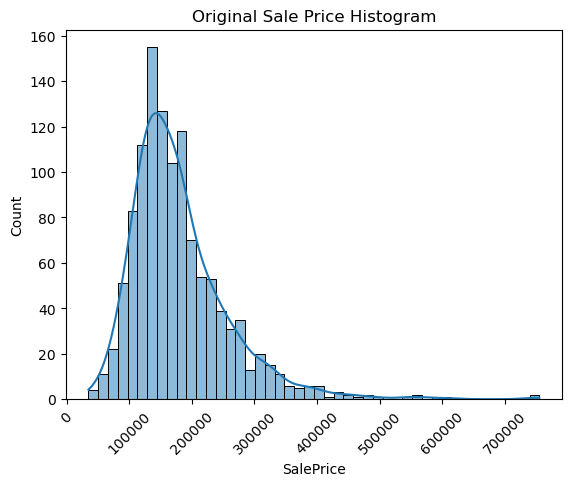

In [4]:
# 타겟 SalePrice 값 분포 확인
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

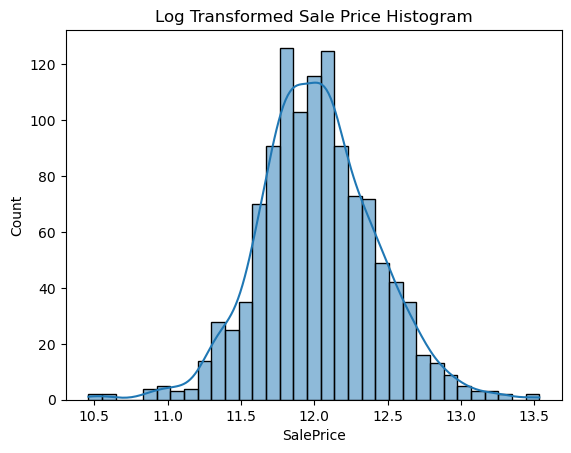

In [5]:
# 타겟 SalePrice 값 로그스케일링을 취하여 정규분포로 근사해기기
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

### 데이터 전처리

In [6]:
# SalePrice값 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 컬럼과 불필요한 컬럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
#드롭하지 않은 숫자형 null 컬럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 타입: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 타입: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [7]:
# Object type(null 값이 있는 피처)에 대해 원-핫 인코딩
print('get_dummies() 수행전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행후 데이터 shape:', house_df_ohe.shape)
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 타입: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행전 데이터 shape: (1168, 75)
get_dummies() 수행후 데이터 shape: (1168, 267)
## Null 피처의 타입: 
 Series([], dtype: object)


### 모델 학습/예측/평가

In [8]:
# 모델 평가 함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그변환된 RMSE:', np.round(rmse, 5))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그변환된 RMSE: 0.13096
Ridge 로그변환된 RMSE: 0.13249
Lasso 로그변환된 RMSE: 0.17727


[0.13096484089028898, 0.13249373932121436, 0.17727257859957432]

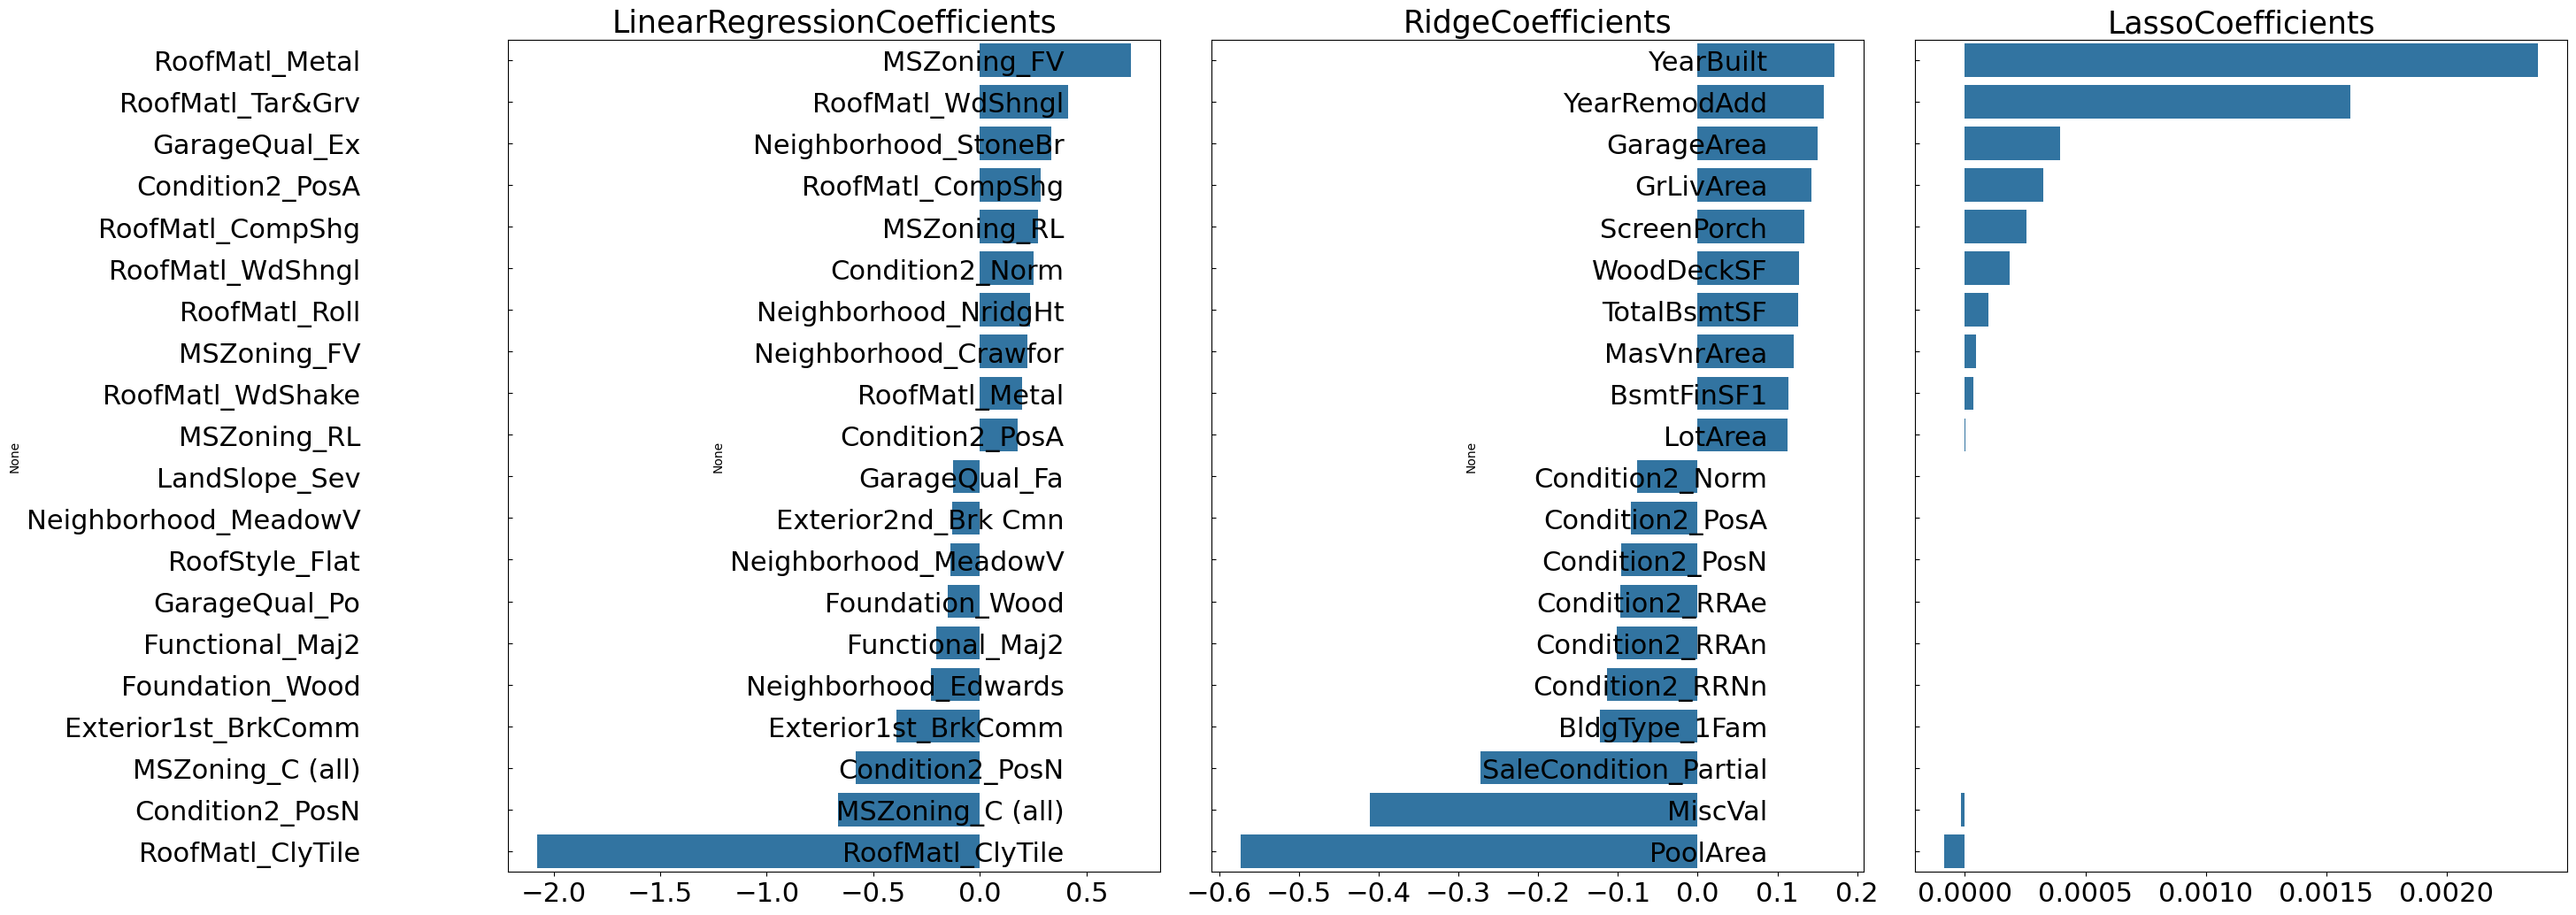

In [10]:
# 피처의 회귀계수 값 확인
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)

    # 상위 10개, 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 이해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()

    #입력인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀계수 시각화
    for i_num, model in enumerate(models):
        #상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판단스 concat로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax_sbuplot에 barchart로 표현
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [11]:
# Cross validation 했을때의 RMSE
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행, 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('\n{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.247 0.196 0.11  0.129 0.116]

LinearRegression CV 평균 RMSE 값: 0.16

Ridge CV RMSE 값 리스트: [0.213 0.172 0.12  0.131 0.119]

Ridge CV 평균 RMSE 값: 0.151

Lasso CV RMSE 값 리스트: [0.287 0.212 0.173 0.185 0.17 ]

Lasso CV 평균 RMSE 값: 0.205


### 하이퍼파라미터 튜닝

In [12]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 cv 시 최적평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적평균 RMSE 값: 0.1509, 최적 alpha: {'alpha': 12}
Lasso 5 cv 시 최적평균 RMSE 값: 0.152, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그변환된 RMSE: 0.13096
Ridge 로그변환된 RMSE: 0.12818
Lasso 로그변환된 RMSE: 0.12242


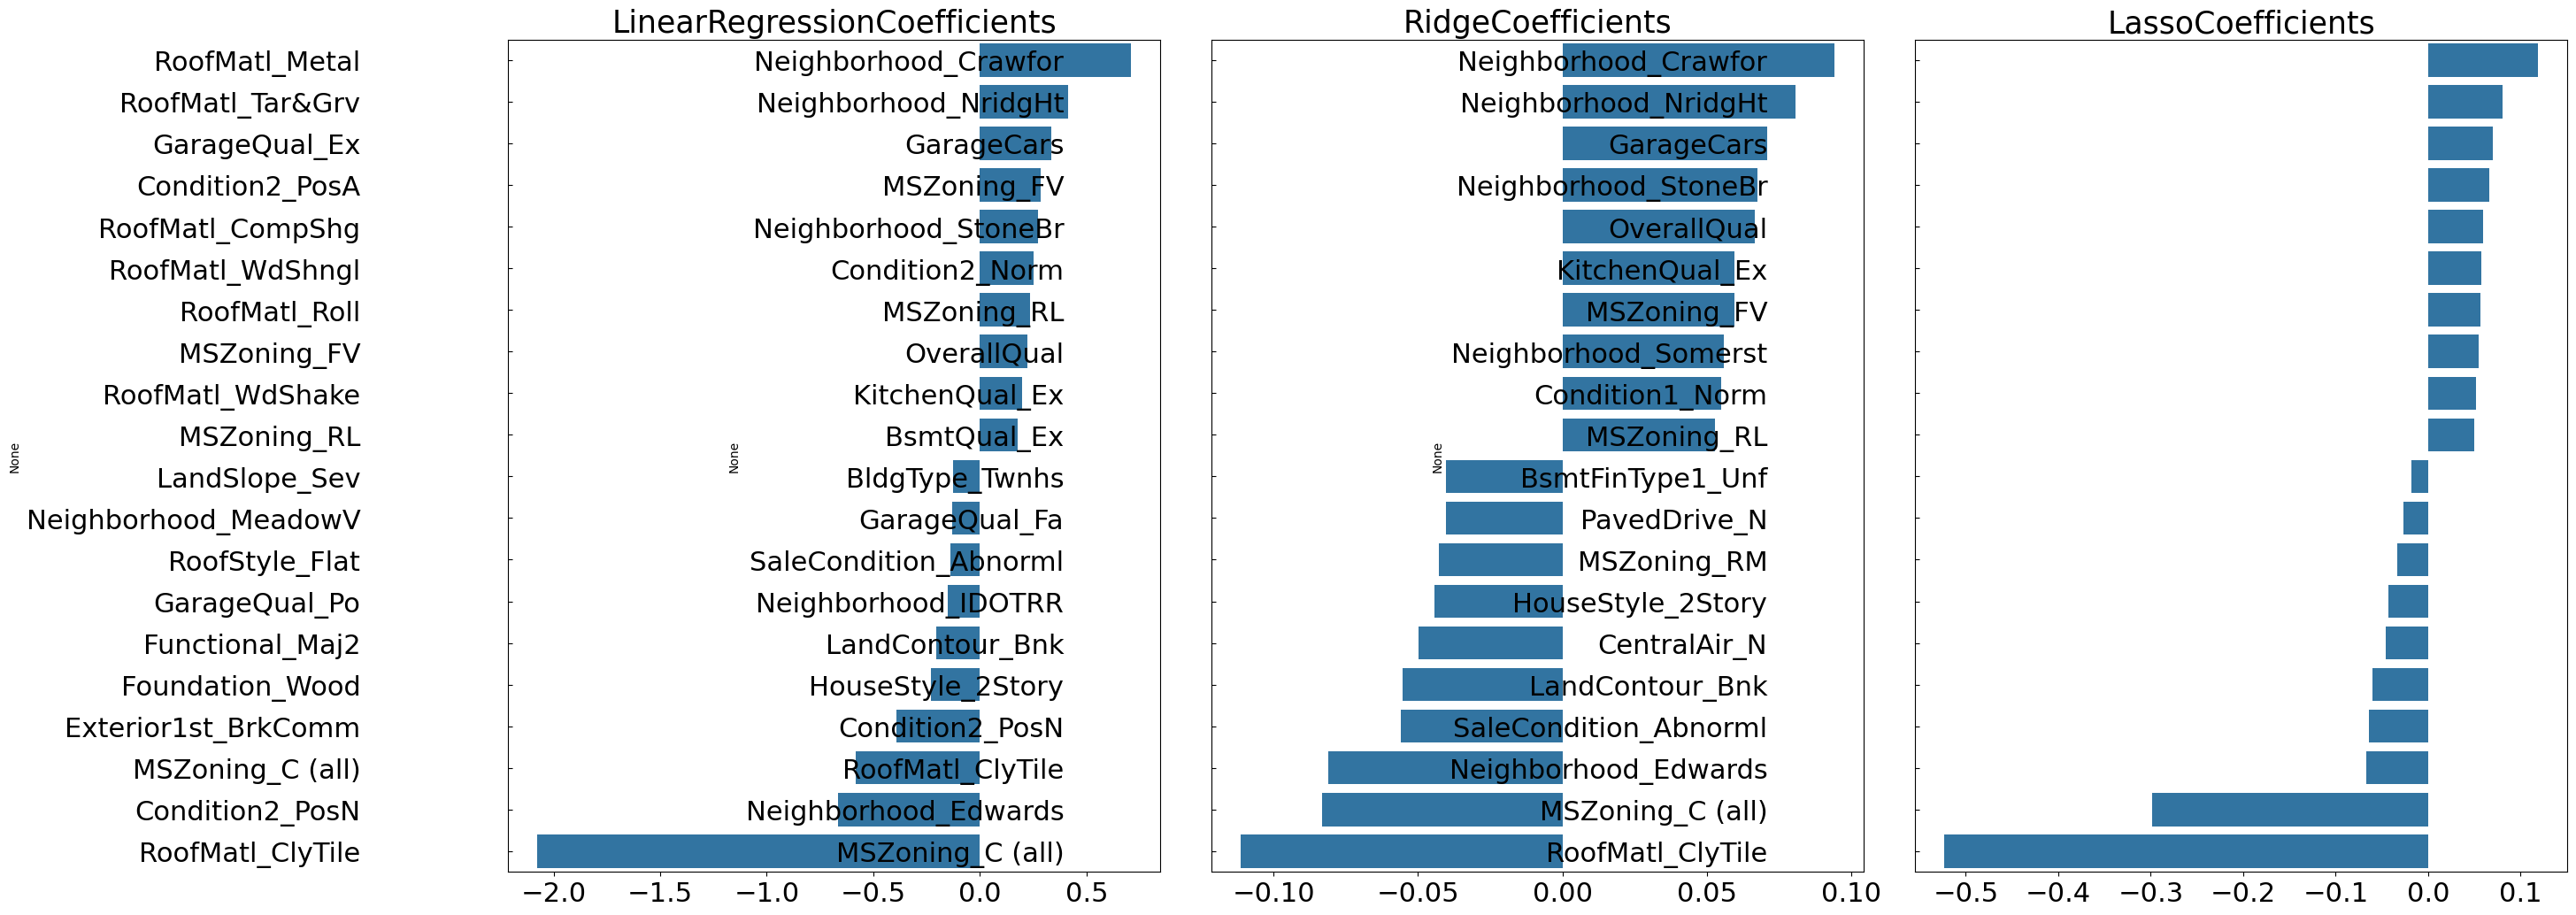

In [13]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
#모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

In [14]:
# 숫자형 컬럼 데이터 skew 확인 및 처리
from scipy.stats import skew

# object가 아닌 숫자형 피처의 컬럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환, apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) wjdehrk 1이상인 컬럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.760540
OpenPorchSF       2.454159
MasVnrArea        2.418589
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


In [15]:
# 왜곡정도가 높은 피처를 로그변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [16]:
# 왜곡 정도가 높은 피처를 로그변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그변환한후 다시 최적 하이퍼파라미터와 RMSE 출력
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적평균 RMSE 값: 0.1332, 최적 alpha: {'alpha': 8}
Lasso 5 cv 시 최적평균 RMSE 값: 0.1296, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그변환된 RMSE: 0.12429
Ridge 로그변환된 RMSE: 0.11579
Lasso 로그변환된 RMSE: 0.11102


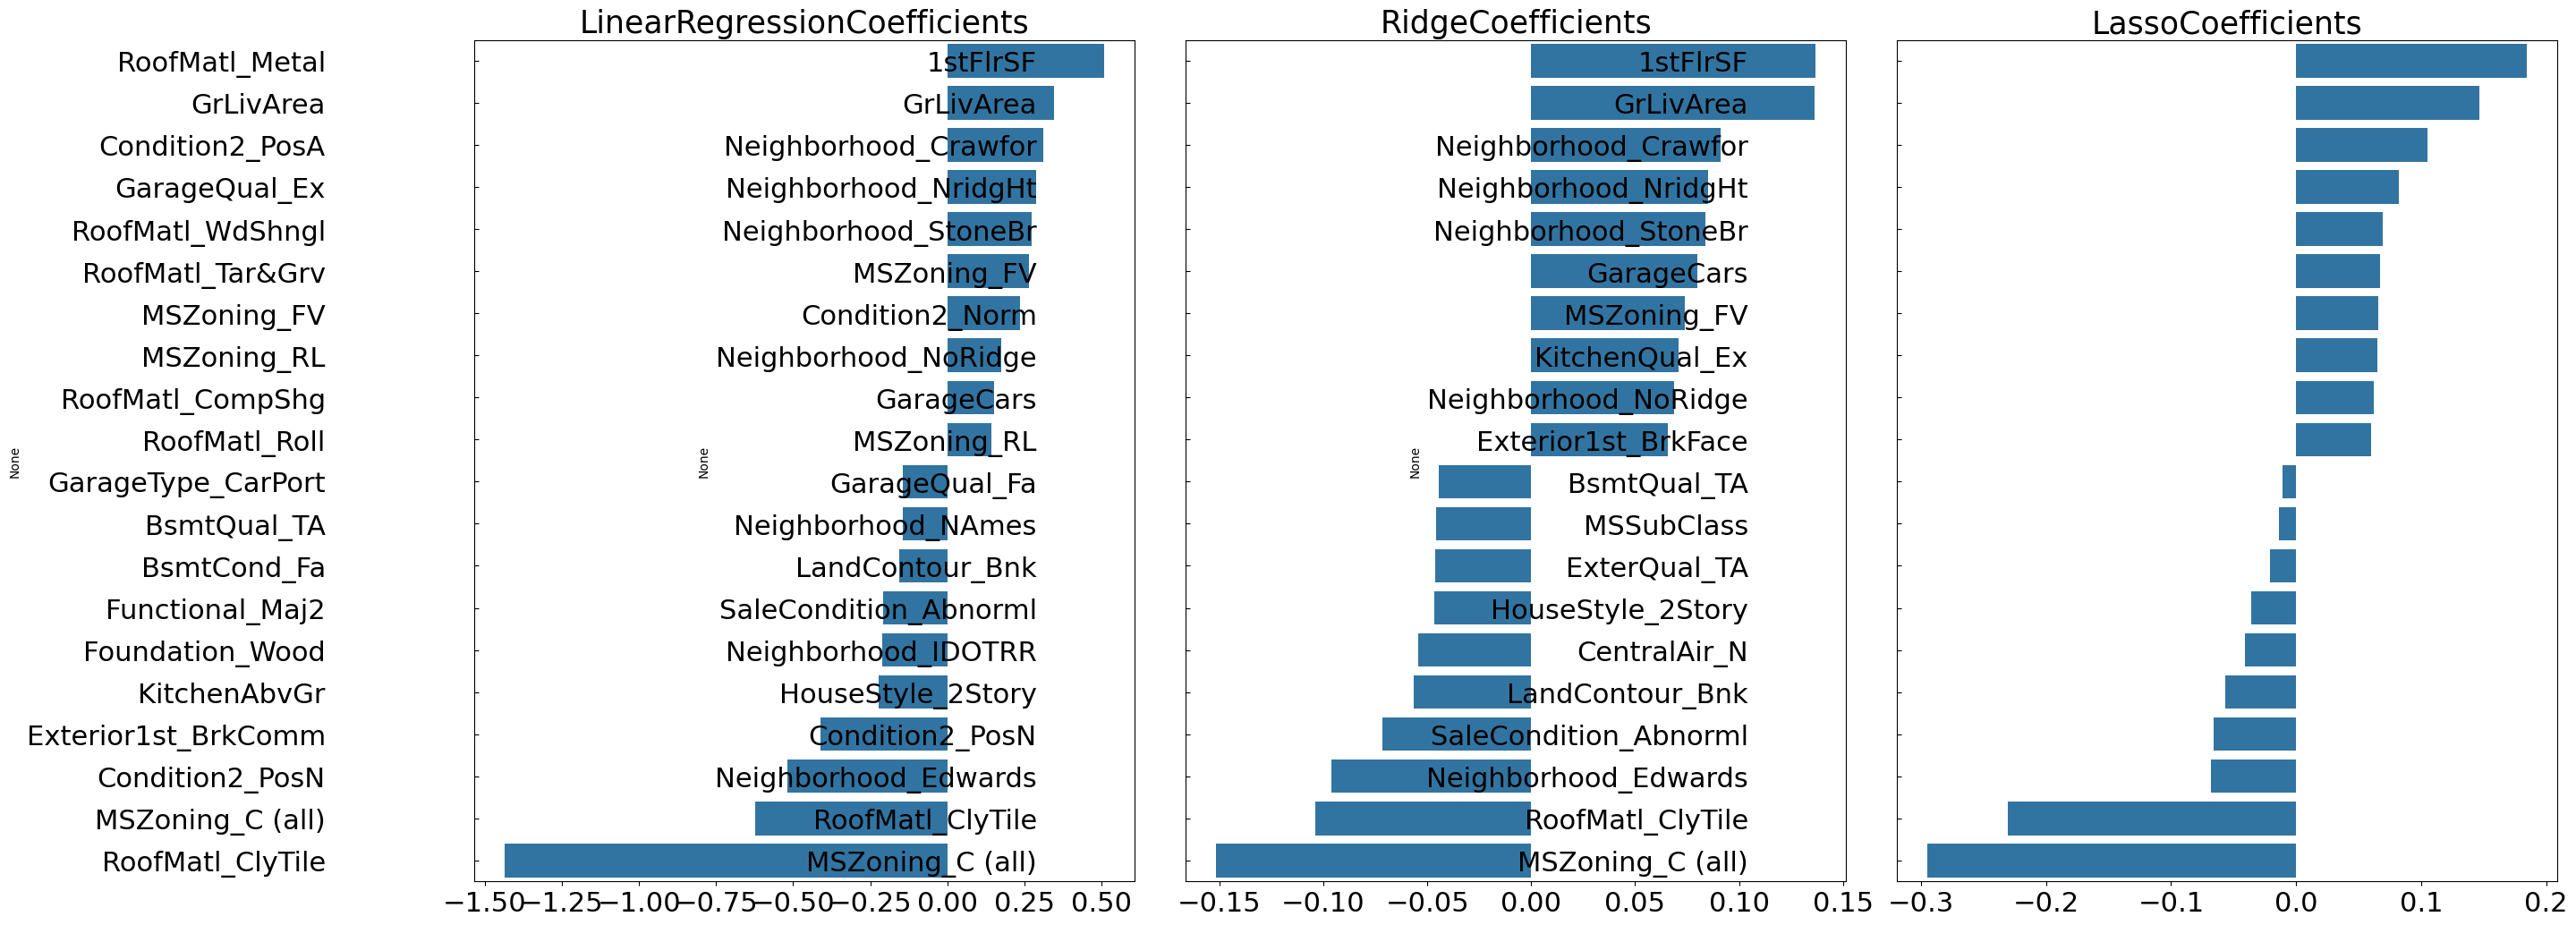

In [17]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
#모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

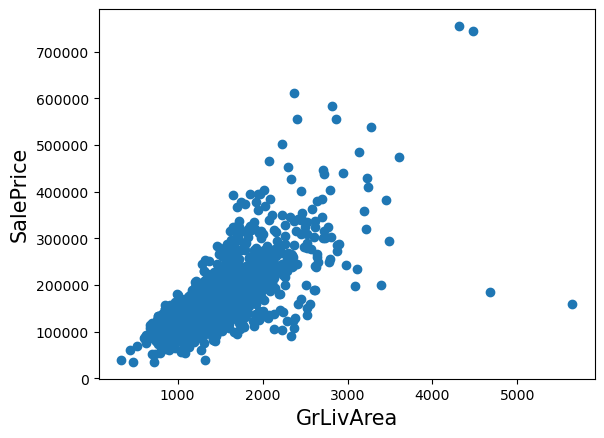

In [18]:
# GrLiveArea와 타깃값 SalePrice와의 관계 시각화
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [19]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제후 house_df_ohe shape:',  house_df_ohe.shape)

이상치 레코드 index: [ 64 373]
이상치 삭제 전 house_df_ohe shape: (1168, 267)
이상치 삭제후 house_df_ohe shape: (1166, 267)


In [20]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그변환한후 다시 최적 하이퍼파라미터와 RMSE 출력
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적평균 RMSE 값: 0.1149, 최적 alpha: {'alpha': 5}
Lasso 5 cv 시 최적평균 RMSE 값: 0.1132, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그변환된 RMSE: 0.12145
Ridge 로그변환된 RMSE: 0.11637
Lasso 로그변환된 RMSE: 0.11198


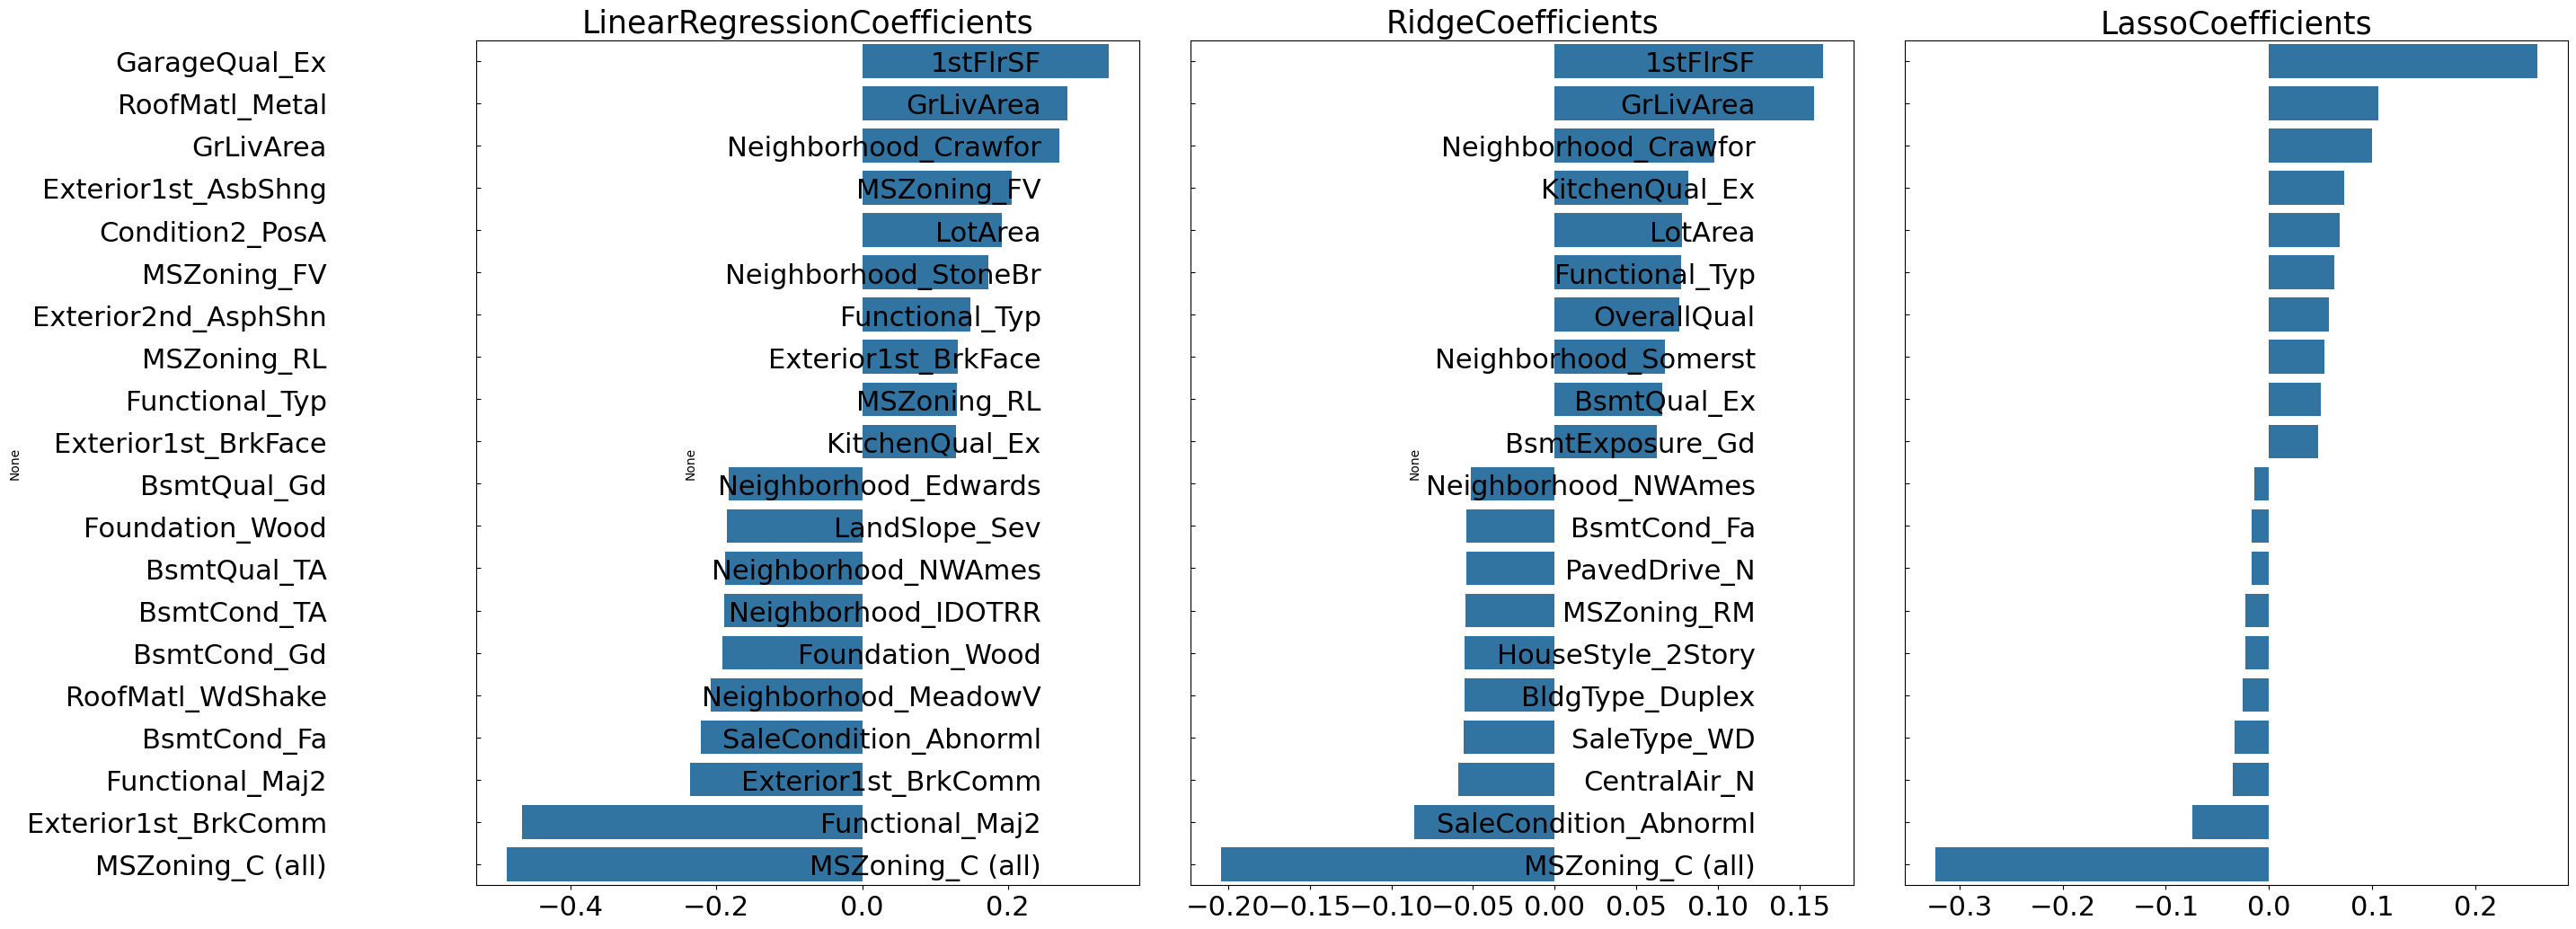

In [21]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
#모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

### XGBoost

In [22]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(X_train, y_train)

print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 cv 시 최적평균 RMSE 값: 0.1246, 최적 alpha: {'n_estimators': 1000}


### LIghtGBM

In [23]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_reg.fit(X_train, y_train)

print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2930
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 155
[LightGBM] [Info] Start training from score 12.029584
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

In [24]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [25]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종혼합': pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

#최종 혼합 모델, 개별 모델의 RMSE값 출력
get_rmse_pred(preds)

최종혼합 모델의 RMSE: 0.11244895301932469
Ridge 모델의 RMSE: 0.11636900372391677
Lasso 모델의 RMSE: 0.11198101452270075


In [26]:
# 개별 모델의 학습
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred

preds = {'최종혼합': pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2930
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 155
[LightGBM] [Info] Start training from score 12.029584
[LightGBM] [Warning] Unknown parameter: subample
최종혼합 모델의 RMSE: 0.11500690216934785
XGBM 모델의 RMSE: 0.11817829916522896
LGBM 모델의 RMSE: 0.11973930669985357


### 스태킹 앙상블 모델을 통한 예측

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [28]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

#각 개별 기반(base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 745, number of used features: 147
[LightGBM] [Info] Start training from score 12.030249
[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Warning] Unknown parameter: subample
	 폴드 세트:  1  시작 
[LightGBM] [Warning] Unknown parameter: subample
[LightGBM] [Warning] Unknown parameter: s

In [29]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

#최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.11062501635552383


### 제출용 test data 전처리

In [30]:
test = pd.read_csv('./modu-ds-4-house-prices/test.csv')

In [31]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(292, 266)

In [32]:
## sample_data를 받아오기
sample = pd.read_csv('./modu-ds-4-house-prices/sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

Id  SalePrice
0      86          0
1     227          0
2     492          0
3      64          0
4     576          0
..    ...        ...
287  1271          0
288   903          0
289  1019          0
290   312          0
291  1056          0

[292 rows x 2 columns]

In [33]:
pred = ridge_reg.predict(test_ohe2)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)